# Plot the UMAPs for a given Model

In [1]:
import json
import matplotlib.pyplot as plt
import os
import time
import logging
from datetime import datetime
from collections import defaultdict
import numpy as np
import torch
import argparse
import scanpy as sc
import re
import math

from fcr import get_model
import matplotlib.colors as mcolors
import seaborn as sns
from glasbey import create_palette

In [5]:
def umap(adata,
         rep,
         return_fig,
         ax=None,
         n_neighbors=15,
         metric="euclidean", 
         min_dist=0.1,   
         size=10,
         color=["cell_name"],
         palette="Set3",
         legend_loc="right margin",
         title=None
         ):
    
    sc.pp.neighbors(adata, use_rep=rep, n_neighbors=n_neighbors, metric=metric)
    sc.tl.umap(adata, min_dist=min_dist)

    norm = mcolors.SymLogNorm(linthresh=0.01, vmin=0, vmax=5)

    figure = sc.pl.umap(
        adata,
        color=color,
        title=title,
        frameon=False,
        palette=palette,
        size=size,
        outline_color="gray",
        outline_width=0.5,
        legend_loc=legend_loc,
        show=False,
        ax=ax,  # allows plotting into an existing axis
        return_fig=return_fig,  # Return if we are using ax = None
        #vcenter=0.01,
        norm=norm
    )

    return figure

def filter_adata(adata, filter_dict):
    """
    Filter an AnnData object based on a filter dictionary.
    
    Parameters
    ----------
    adata : AnnData
        The AnnData object to filter.
    filter_dict : dict
        Dictionary specifying filters to apply on the data (e.g., {"drug": "DMSO_TF"}).
        
    Returns
    -------
    AnnData
        Filtered AnnData object.
    """
    mask = np.ones(adata.n_obs, dtype=bool)
    filter_suffix = ""
    
    for key, value in filter_dict.items():
        if key not in adata.obs.columns:
            print(f"Warning: '{key}' not found in adata.obs. Skipping this filter.")
            continue
        
        # Handle single value or list of values
        if isinstance(value, (list, tuple)):
            mask &= adata.obs[key].isin(value)
            filter_suffix += f"_{'_'.join(str(v) for v in value)}"
        else:
            mask &= (adata.obs[key] == value)
            filter_suffix += f"_{value}"

    # Subset adata
    n_before = adata.n_obs
    adata_sub = adata[mask].copy()
    n_after = adata_sub.n_obs
    print(f"Applied filters: {filter_dict}")
    print(f"Samples: {n_before} → {n_after} ({n_after/n_before*100:.1f}%)")
    
    return [adata_sub, filter_suffix]

In [10]:
# Adata is supposed to already have the embeddings precomputed
def plot_umaps(model_dir,
               adata_path,
               max_samples = 50_000,
               n_checkpoint=None, 
               plot_raw=False,
               plot_all=False,
               plot_zx=False,
               plot_zxt=False,
               plot_zt=False, 
               target_epoch=None, 
               # drug_dict=None, 
               # cell_dict=None,
               filter_dict=None, 
               all_drugs=False, 
               sample=False, 
               show_figs=False):
    """
    Plot UMAPs for FCR latent representations.
    
    Parameters
    ----------
    model_dir : str
        Path to model directory
    target_epoch : int, optional
        Specific epoch to load
    filter_dict : dict, optional
        Dictionary of filters to apply to adata before plotting.
        Usage: mainly to select drugs if there are several
        Format: {column_name: value} or {column_name: [list_of_values]}
        Examples:
            {'Agg_Treatment': 'Trametinib'}  # Only Trametinib samples
            {'Agg_Treatment': ['Trametinib', 'Dabrafenib']}  # Multiple drugs
            {'cell_name': 'A375', 'dose': 10}  # Multiple conditions
    """

    # Define plotting mode
    if not plot_zx and not plot_zxt and not plot_zt:
        plot_all = True

    args, model = get_model(model_dir, target_epoch, return_dataset=False)

    # Load AnnData
    print(f"Loading AnnData from {adata_path}") 
    adata = sc.read(adata_path)

    # Subset dataset speed up computation
    rng = np.random.default_rng(42)
    n_cells = adata.n_obs
    subset_size = max_samples if n_cells > max_samples else n_cells
    
    idx = rng.choice(n_cells, size=subset_size, replace=False)
    
    # Subset to reduce computation time
    print(f"Subsetting AnnData to {subset_size} samples")
    adata = adata[idx].copy()

    # Set output directory
    # Can specify model checkpoint index
    if n_checkpoint is not None:
        output_dir = str(os.path.join(model_dir, "umaps", f"checkpoint_{n_checkpoint}"))
    else:
        output_dir = str(os.path.join(model_dir, "umaps"))
    os.makedirs(output_dir, exist_ok=True)

    # Apply filters if provided
    """
    if drug_dict is not None:
        adata_drug, drug_suffix = filter_adata(adata, drug_dict)
    else:
        drug_suffix = ""
        adata_drug = adata

    if cell_dict is not None:
        adata_cell, cell_suffix = filter_adata(adata, cell_dict)
    else:
        cell_suffix = ""
        adata_cell = adata
    """
    if filter_dict is not None:
        adata_sub, filter_suffix = filter_adata(adata, filter_dict)
        # The following does not work for perturbation_input="ohe", because the size of
        # the treatment embeddings depends on the treatments present in the dataset 
        #new_datasets = prepare_dataset(
        #    args,
        #    data_path=None,
        #    split_name="all",
        #    adata=adata_sub
        #)
        #new_splits = new_datasets[0]
    else:
        adata_sub = adata
        #new_splits = splits
        filter_suffix = ""

    # Generate palette
    n = adata.obs["cell_name"].nunique()
    palette = create_palette(palette_size=n)

    # Plot ZX
    if plot_all or plot_zx:
        print("Plotting ZX UMAP...")
        fig = umap(adata_sub, rep="ZXs", color=["cell_name"], palette=palette, return_fig=True)
        if show_figs:
            plt.show()
        else:
            fig.savefig(os.path.join(output_dir,f"UMAP_ZXs{filter_suffix}.png"), dpi=300, bbox_inches="tight")
        plt.close()

    # Plot ZXT
    if plot_all or plot_zxt:
        print("Plotting ZXT UMAP...")
        fig = umap(adata_sub, rep="ZXTs", color=["cell_name"], return_fig=True)
        if show_figs:
            plt.show()
        else:
            fig.savefig(os.path.join(output_dir,f"UMAP_ZXTs{filter_suffix}.png"), dpi=300, bbox_inches="tight")
        plt.close()

    # Plot ZT
    if plot_all or plot_zt:
        if not all_drugs:
            print("Plotting ZT UMAP...")
            fig = umap(adata_sub, rep="ZTs", color=["cell_name"], return_fig=True)
            if show_figs:
                plt.show()
            else:
                fig.savefig(os.path.join(output_dir,f"UMAP_ZTs{filter_suffix}.png"), dpi=300, bbox_inches="tight")
            plt.close()
            
        # Option: print ZT against all drugs
        else:
            drugs_plot = [drug for drug in adata.obs["Agg_Treatment"].unique() if drug != "DMSO_TF"]
            for drug in drugs_plot:
                print(f"Plotting ZT UMAP for drug: {drug}...")
                filter_dict = {"Agg_Treatment": [drug, "DMSO_TF"]}
                adata_sub, filter_suffix = filter_adata(adata, filter_dict)
                fig = umap(adata_sub, rep="ZTs", color=["dose", "Agg_Treatment", "cell_name"], return_fig=True)
                if show_figs:
                    plt.show()
                else:
                    fig.savefig(os.path.join(output_dir,f"UMAP_ZTs_{filter_suffix}.png"), dpi=300, bbox_inches="tight")
                plt.close()

    # Plot before FCR
    if plot_raw:
        print("Plotting raw UMAPs...")
        fig = raw_umap(adata_sub, feature="cell_name")
        if show_figs:
            plt.show()
        else:
            fig.savefig(os.path.join(output_dir,f"UMAP_cell_name{filter_suffix}.png"), dpi=300, bbox_inches="tight")

        fig = raw_umap(adata_sub, feature="Agg_Treatment")
        if show_figs:
            plt.show()
        else:
            fig.savefig(os.path.join(output_dir,f"UMAP_treatment{filter_suffix}.png"), dpi=300, bbox_inches="tight")

        fig = raw_umap(adata_sub, feature="dose")
        if show_figs:
            plt.show()
        else:
            fig.savefig(os.path.join(output_dir,f"UMAP_dose{filter_suffix}.png"), dpi=300, bbox_inches="tight")
        plt.close()

Model path: /cluster/work/bewi/members/rquiles/experiments/GDSC_controls/run1/saves/GDSC_controls_2025.12.14_03:03:43/model_seed=42_epoch=49.pt
Loading AnnData from /cluster/work/bewi/data/tahoe100/h5ad/gdsc_controls_processed_fcr.h5ad
Subsetting AnnData to 50000 samples
Plotting ZX UMAP...


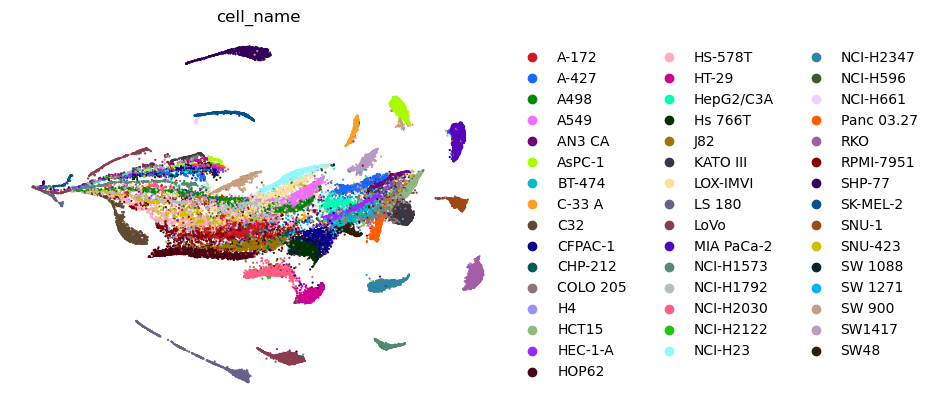

Plotting ZXT UMAP...


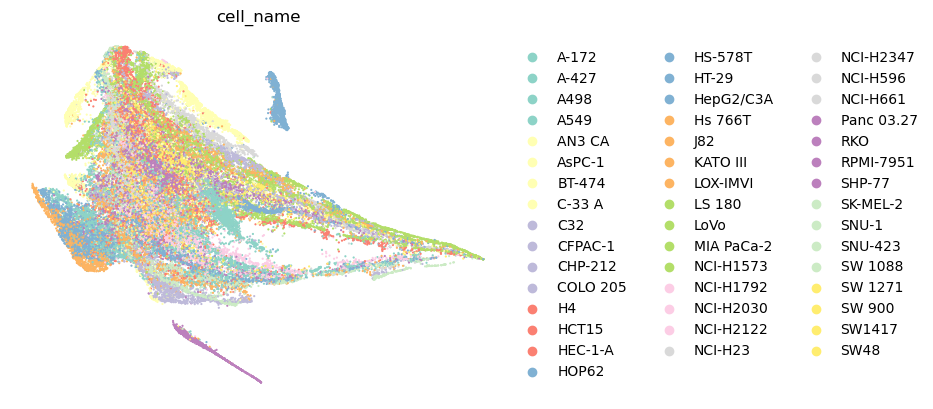

In [12]:
model_dir = "/cluster/work/bewi/members/rquiles/experiments/GDSC_controls/run1"
adata_path = "/cluster/work/bewi/data/tahoe100/h5ad/gdsc_controls_processed_fcr.h5ad"
plot_umaps(model_dir, adata_path, plot_zx=True, plot_zxt=True)

In [13]:
# Save plots to corresponding directory
model_dir = "/cluster/work/bewi/members/rquiles/experiments/GDSC_controls/run1"
adata_path = "/cluster/work/bewi/data/tahoe100/h5ad/gdsc_controls_processed_fcr.h5ad"
plot_umaps(model_dir, adata_path, plot_zx=True, plot_zxt=True)

Model path: /cluster/work/bewi/members/rquiles/experiments/GDSC_controls/run1/saves/GDSC_controls_2025.12.14_03:03:43/model_seed=42_epoch=49.pt
Loading AnnData from /cluster/work/bewi/data/tahoe100/h5ad/gdsc_controls_processed_fcr.h5ad
Subsetting AnnData to 50000 samples
Plotting ZX UMAP...
Plotting ZXT UMAP...
